# Group Classifier Embeddings

This notebook compares:
- **Input space** (graph-level features derived from raw inputs)
- **Model embedding space** (true latent vectors from `model.extract_embeddings(...)`)

It uses a trained exported model, rebuilds the eager model, and extracts embeddings directly.


In [1]:
import json
from pathlib import Path
from datetime import datetime

import numpy as np
import torch

from pioneerml.common.loader import GroupClassifierGraphLoader
from pioneerml.common.models.classifiers import GroupClassifier
from pioneerml.common.evaluation.plots import plot_embedding_space
from pioneerml.common.zenml import utils as zenml_utils

PROJECT_ROOT = zenml_utils.find_project_root()
zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Project root: {PROJECT_ROOT}")
print(f"Device: {device}")


Using ZenML repository root: /workspace
Ensure this is the top-level of your repo (.zen must live here).
Project root: /workspace
Device: cuda


## Inputs

By default this notebook:
- uses all `data/ml_output_*.parquet` files
- picks the latest model in `trained_models/groupclassifier`


In [2]:
# Data inputs
data_dir = Path(PROJECT_ROOT) / "data"
parquet_paths = sorted(data_dir.glob("ml_output_*.parquet"))

# Optional quick subset
# parquet_paths = parquet_paths[:1]

parquet_paths = [str(p.resolve()) for p in parquet_paths]
if not parquet_paths:
    raise RuntimeError(f"No parquet files found in {data_dir}")

# Latest model artifacts
model_dir = Path(PROJECT_ROOT) / "trained_models" / "groupclassifier"
meta_candidates = sorted(model_dir.glob("*_meta.json"), key=lambda p: p.stat().st_mtime, reverse=True)
if not meta_candidates:
    raise RuntimeError(f"No metadata files found in {model_dir}")

meta_path = meta_candidates[0]
meta = json.loads(meta_path.read_text())
torchscript_path = Path(meta.get("torchscript_path") or str(meta_path).replace("_meta.json", "_torchscript.pt"))
if not torchscript_path.exists():
    raise FileNotFoundError(f"TorchScript file not found: {torchscript_path}")

print(f"Using metadata:    {meta_path}")
print(f"Using torchscript: {torchscript_path}")
print(f"Num parquet files: {len(parquet_paths)}")


Using metadata:    /workspace/trained_models/groupclassifier/groupclassifier_20260218_231152_meta.json
Using torchscript: /workspace/trained_models/groupclassifier/groupclassifier_20260218_231152_torchscript.pt
Num parquet files: 5


## Rebuild Eager Model

`extract_embeddings` is an eager method, so we load TorchScript weights into a normal `GroupClassifier` instance.


In [3]:
def _strip_prefix(state_dict: dict[str, torch.Tensor], prefix: str = "model.") -> dict[str, torch.Tensor]:
    out: dict[str, torch.Tensor] = {}
    for key, value in state_dict.items():
        out[key[len(prefix):] if key.startswith(prefix) else key] = value
    return out

hpo_params = dict(meta.get("hpo_params") or {})
model_cfg = dict(hpo_params.get("model") or {})
data_shapes = dict(meta.get("data_shapes") or {})

cfg = {
    "in_dim": int(model_cfg.get("in_dim", data_shapes.get("x_dim", 4))),
    "edge_dim": int(model_cfg.get("edge_dim", data_shapes.get("edge_attr_dim", 4))),
    "hidden": int(model_cfg.get("hidden", 200)),
    "heads": int(model_cfg.get("heads", 4)),
    "num_blocks": int(model_cfg.get("num_blocks", model_cfg.get("layers", 2))),
    "dropout": float(model_cfg.get("dropout", 0.1)),
    "num_classes": int(data_shapes.get("num_classes", 3)),
}

model = GroupClassifier(**cfg)
scripted = torch.jit.load(str(torchscript_path), map_location="cpu")
state = _strip_prefix(scripted.state_dict(), prefix="model.")
missing, unexpected = model.load_state_dict(state, strict=False)

print("Model config:", cfg)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

model = model.to(device)
model.eval()


Model config: {'in_dim': 4, 'edge_dim': 4, 'hidden': 219, 'heads': 3, 'num_blocks': 3, 'dropout': 0.00013525814404249437, 'num_classes': 3}
Missing keys: []
Unexpected keys: []


GroupClassifierStereo(
  (input_embed): ViewAwareEncoder(
    (feature_proj): Linear(in_features=3, out_features=219, bias=True)
    (view_embedding): Embedding(2, 219)
  )
  (blocks): ModuleList(
    (0-2): 3 x FullGraphTransformerBlock(
      (ln1): LayerNorm((219,), eps=1e-05, elementwise_affine=True)
      (attn): TransformerConv(219, 73, heads=3)
      (ln2): LayerNorm((219,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=219, out_features=876, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.00013525814404249437, inplace=False)
        (3): Linear(in_features=876, out_features=219, bias=True)
      )
    )
  )
  (jk): JumpingKnowledge(cat)
  (pool_x): AttentionalAggregation(gate_nn=Sequential(
    (0): Linear(in_features=657, out_features=328, bias=True)
    (1): ReLU()
    (2): Linear(in_features=328, out_features=1, bias=True)
  ), nn=None)
  (pool_y): AttentionalAggregation(gate_nn=Sequential(
    (0): Linear(in_features=65

## Collect Input Features And Embeddings

Each sample is one graph (time-group graph):
- input feature vector = mean of node features in that graph
- embedding vector = `model.extract_embeddings(batch)[graph_id]`


In [4]:
max_samples = 8000
batch_size = 256

loader = GroupClassifierGraphLoader(
    parquet_paths=parquet_paths,
    mode="train",
    batch_size=batch_size,
    row_groups_per_chunk=4,
    num_workers=0,
)

input_feats: list[np.ndarray] = []
input_targets: list[np.ndarray] = []
embedding_list: list[torch.Tensor] = []
embedding_targets: list[torch.Tensor] = []
num_collected = 0

with torch.no_grad():
    for batch in loader.make_dataloader(shuffle_batches=False):
        # Input-space features (CPU)
        x_cpu = batch.x.cpu()
        y_cpu = batch.y.cpu()
        b_cpu = batch.batch.cpu()
        n_graphs = int(batch.num_graphs)

        for gid in range(n_graphs):
            idx = torch.nonzero(b_cpu == gid, as_tuple=False).view(-1)
            if idx.numel() == 0:
                continue
            input_feats.append(x_cpu[idx].mean(dim=0).numpy())
            input_targets.append(y_cpu[gid].numpy())

        # True model embeddings
        batch = batch.to(device)
        emb = model.extract_embeddings(batch).detach().cpu()
        embedding_list.append(emb)
        embedding_targets.append(batch.y.detach().cpu())

        num_collected += emb.size(0)
        if num_collected >= max_samples:
            break

if not embedding_list:
    raise RuntimeError("No embeddings collected. Check inputs and loader configuration.")

input_feats = np.asarray(input_feats, dtype=np.float32)[:max_samples]
input_targets = np.asarray(input_targets, dtype=np.float32)[:max_samples]
embeddings = torch.cat(embedding_list, dim=0)[:max_samples]
targets = torch.cat(embedding_targets, dim=0)[:max_samples]

print(f"Input features shape: {tuple(input_feats.shape)}")
print(f"Embeddings shape:     {tuple(embeddings.shape)}")
print(f"Targets shape:        {tuple(targets.shape)}")


Input features shape: (8000, 4)
Embeddings shape:     (8000, 1316)
Targets shape:        (8000, 3)


## Plot Input Space

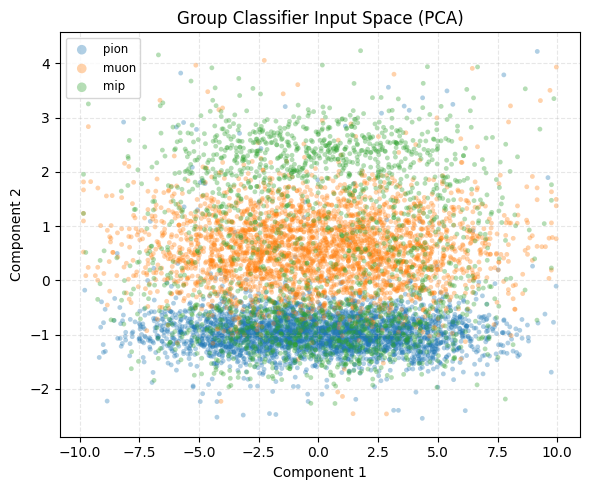

[embedding] Pre-reduced to 4 dims via PCA.


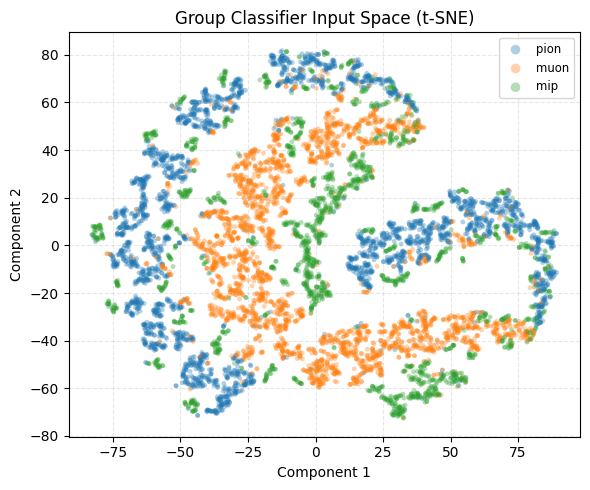

'/workspace/artifacts/validation_plots/group_classifier_embeddings/group_classifier_embeddings_20260218_231343_input_space_tsne.png'

In [5]:
plots_dir = Path(PROJECT_ROOT) / "artifacts" / "validation_plots" / "group_classifier_embeddings"
plots_dir.mkdir(parents=True, exist_ok=True)

timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")
plot_prefix = f"group_classifier_embeddings_{timestamp_str}"
class_names = ["pion", "muon", "mip"]

plot_embedding_space(
    embeddings=input_feats,
    targets=input_targets,
    class_names=class_names,
    method="pca",
    title="Group Classifier Input Space (PCA)",
    random_state=42,
    max_samples=max_samples,
    save_path=plots_dir / f"{plot_prefix}_input_space_pca.png",
    show=True,
    verbose=True,
)

plot_embedding_space(
    embeddings=input_feats,
    targets=input_targets,
    class_names=class_names,
    method="tsne",
    title="Group Classifier Input Space (t-SNE)",
    random_state=42,
    max_samples=max_samples,
    pre_pca_components=4,
    save_path=plots_dir / f"{plot_prefix}_input_space_tsne.png",
    show=True,
    verbose=True,
)


## Plot Embedding Space

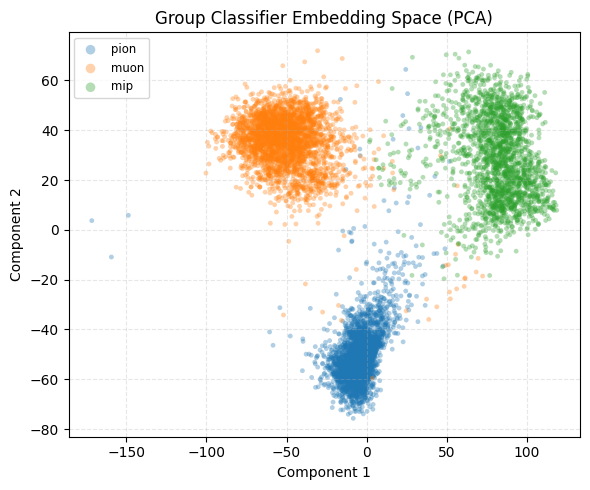

[embedding] Pre-reduced to 50 dims via PCA.


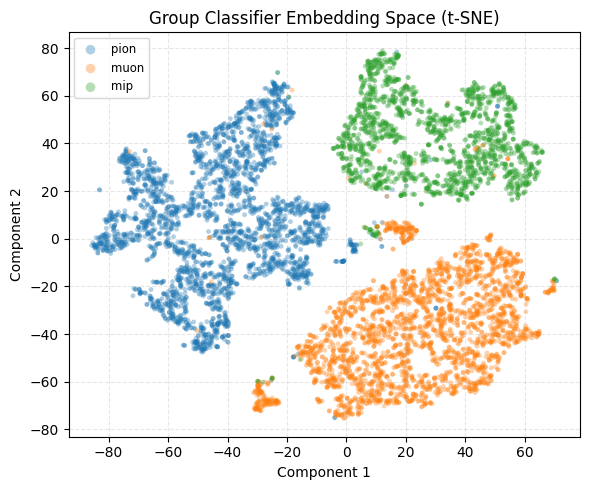

Saved plots to: /workspace/artifacts/validation_plots/group_classifier_embeddings


In [6]:
plot_embedding_space(
    embeddings=embeddings,
    targets=targets,
    class_names=class_names,
    method="pca",
    title="Group Classifier Embedding Space (PCA)",
    random_state=42,
    max_samples=max_samples,
    save_path=plots_dir / f"{plot_prefix}_embedding_space_pca.png",
    show=True,
    verbose=True,
)

plot_embedding_space(
    embeddings=embeddings,
    targets=targets,
    class_names=class_names,
    method="tsne",
    title="Group Classifier Embedding Space (t-SNE)",
    random_state=42,
    max_samples=max_samples,
    pre_pca_components=50,
    save_path=plots_dir / f"{plot_prefix}_embedding_space_tsne.png",
    show=True,
    verbose=True,
)

print(f"Saved plots to: {plots_dir}")


## Interpretation

- Compare **input-space overlap** vs **embedding-space overlap**.
- Better class separation in embedding space indicates useful learned representation.
